In [11]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [12]:
actions = [
    '안녕하세요',
    '만나다',
    '반갑다'
]

data = np.concatenate([
    np.load('dataset/0_안녕하세요_.npy'),
    np.load('dataset/1_만나다_.npy'),
    np.load('dataset/2_반갑다_.npy'),
], axis=0)

data.shape

(1318, 30, 199)

In [13]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape) # 라벨의 원핫 인코딩 필요

# print('\n수어 인덱스')
# idxes = {}
# for i in labels:
#     if i not in idxes:
#         idxes[i] = True
#         print(i)

(1318, 30, 198)
(1318,)


In [14]:
# 원핫 인코딩
# ex
# 0 [1, 0, 0]
# 1 [0, 1, 0]
# 2 [0, 0, 1]

from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1318, 3)

In [15]:
# 데이터를 학습(train)과 검증(validation) 세트로 나눔 -> 모델의 성능을 평가 && 과적합 방지
# 과적합: 데이터 크기 작을 때 || 단일 샘플 데이터 세트 장기간 훈련
# x: 입력, y: 출력
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3, random_state=2021) # test_size 조정

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(922, 30, 198) (922, 3)
(396, 30, 198) (396, 3)


In [20]:
# 모델 구조 정의, 컴파일
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam

# model = Sequential([
#     LSTM(64, activation='relu', input_shape=x_train.shape[1:3]), # (512,30,198)[1:3] => (30,198): (시퀀스 길이, 특징 수)
#     Dense(32, activation='relu'),
#     Dense(len(actions), activation='softmax')
# ])
# model = Sequential([
#     Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=x_train.shape[1:]), # Convolutional layer 추가
#     MaxPooling1D(pool_size=2),  # MaxPooling layer 추가
#     LSTM(64, activation='relu'), # LSTM layer 유지
#     Dropout(0.5),  # Dropout layer 추가
#     Dense(32, activation='relu'), # Dense layer
#     Dense(16, activation='relu'), # Dense layer 추가
#     Dropout(0.5),  # Dropout layer 추가
#     Dense(len(actions), activation='softmax')  # Output layer 유지
# ])

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]), # (512,30,198)[1:3] => (30,198): (시퀀스 길이, 특징 수)
    Dense(64, activation='relu'), # Dense layer
    Dense(64, activation='relu'), # Dense layer
    Dropout(0.3),  # Dropout layer 추가
    Dense(64, activation='relu'), # Dense layer
    Dense(64, activation='relu'), # Dense layer
    Dense(64, activation='relu'), # Dense layer
    Dropout(0.3),  # Dropout layer 추가
    Dense(64, activation='relu'), # Dense layer 추가
    Dense(len(actions), activation='softmax')  # Output layer 유지
])

optimizer = Adam(learning_rate=0.001) # 예시로 학습률을 0.001로 설정

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 30, 32)            19040     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)               

In [21]:
# 모델 훈련 (epochs=200: 학습량)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('model_ko.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/50
28/29 [===========================>..] - ETA: 0s - loss: 2.6863 - acc: 0.5257
Epoch 00001: val_acc improved from -inf to 1.00000, saving model to model_ko.h5
29/29 [==============================] - 1s 49ms/step - loss: 2.6221 - acc: 0.5325 - val_loss: 0.3152 - val_acc: 1.0000
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.6601 - acc: 0.6952
Epoch 00002: val_acc did not improve from 1.00000
29/29 [==============================] - 1s 22ms/step - loss: 0.6601 - acc: 0.6952 - val_loss: 0.2348 - val_acc: 1.0000
Epoch 3/50
28/29 [===========================>..] - ETA: 0s - loss: 0.5069 - acc: 0.8036
Epoch 00003: val_acc did not improve from 1.00000
29/29 [==============================] - 1s 22ms/step - loss: 0.5034 - acc: 0.8048 - val_loss: 0.1245 - val_acc: 1.0000
Epoch 4/50
28/29 [===========================>..] - ETA: 0s - loss: 0.4061 - acc: 0.8549
Epoch 00004: val_acc did not improve from 1.00000
29/29 [==============================] - 1s 22ms/step 

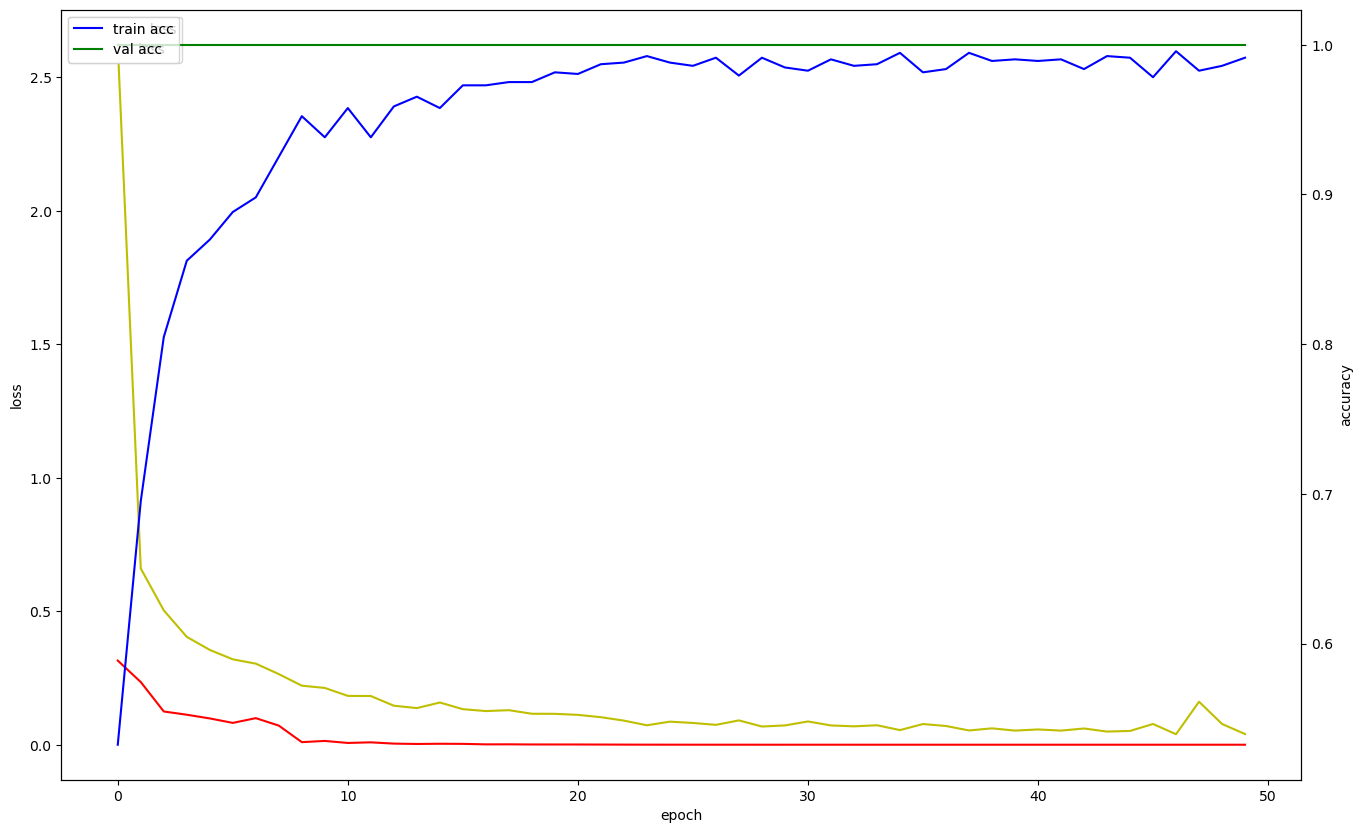

In [22]:
# 훈련 과정에서 발생한 손실(loss) 및 정확도(accuracy)를 시각화

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss') #노랑: 학습 데이터셋 기반 모델의 손실
loss_ax.plot(history.history['val_loss'], 'r', label='val loss') #빨강: 검증 데이터셋 기반 모델의 손실
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc') # 파랑: 학습 데이터셋 기반 모델 정확도
acc_ax.plot(history.history['val_acc'], 'g', label='val acc') #녹색: 검증 데이터셋 기반 모델 정확도
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [23]:
# 모델의 예측 결과와 실제 레이블 간의 다중 레이블 혼동 행렬(multilabel confusion matrix)을 계산하는 작업을 수행

from sklearn.metrics import multilabel_confusion_matrix


y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

# 실행 결과 예시
# WARNING:tensorflow:Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
# array([[[94,  1],
#         [ 0, 34]],

#        [[81,  0],
#         [ 0, 47]],

#        [[81,  0],
#         [ 0, 47]]])

# 예시로 해석
# True Positive (TP): 모델이 양성(Positive)으로 예측한 것 중에서 실제로 양성인 경우의 수. (94)
# True Negative (TN): 모델이 음성(Negative)으로 예측한 것 중에서 실제로 음성인 경우의 수. (34))
# False Positive (FP): 모델이 양성(Positive)으로 잘못 예측한 것 중에서 실제로는 음성인 경우의 수. (0: 모델이 양성으로 잘못 예측한 경우가 없음)
# False Negative (FN): 모델이 음성(Negative)으로 잘못 예측한 것 중에서 실제로는 양성인 경우의 수. (1)

array([[[267,   0],
        [  0, 129]],

       [[270,   0],
        [  0, 126]],

       [[255,   0],
        [  0, 141]]], dtype=int64)